# Chapter 3.2 - Solving Antennas Selection Problem Using Qbool

In this chapter we will see how to analyze real world problems and break them down into a quantum expressions and assignments that can be solved by a quantum computer or simulator.

Before we begin, we need to activate the default solver, which will be used to solve quantum problems in this chapter.

In [1]:
from dann5.dwave import Solver
print(Solver.Active())

## Antennas Selection Problem

The problem is called the Antennas Selection issue. Looking at the image below we see 7 antennas and we need to see all possible selections of which to turn on so that they do not interfere with each other. While maximizing coverage. Any antenna (vertex) that is connected with a line (edge) will interfere with one another. For example, in the figure below, if both antenna 1 and 2 are on there will be an interference.

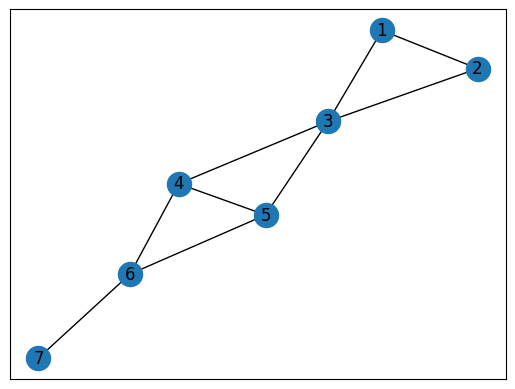

Now we will devise an expression using *Qbool* variables to symbolize the antennas to see all the possibilities where we can have the maximum number of antennas on without any interferences.

First, to represent the antennas, we are initializing seven *Qbool* variables in superposition state (unknown value). Also, we are initializing *antOn Qbool* variable to value *True*, which will represent antenna's status on when we retrieve only correct solutions through an application of a quantum assignment.

In [2]:
from dann5.d5 import Qbool

ant1 = Qbool("ant1"); ant2 = Qbool("ant2"); ant3 = Qbool("ant3"); ant4 = Qbool("ant4")
ant5 = Qbool("ant5"); ant6 = Qbool("ant6"); ant7 = Qbool("ant7")
antOn = Qbool("antOn", True)

print(ant1, ant2, ant3, ant4, ant5, ant6, ant7, antOn)

ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ ant7\S\ antOn\T\


### One antenna problem and deterministic expression

Going step by step, we will start with one antenna which is quite simple to express.

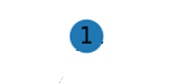

Obviously in this case there is no interference, and the antenna 1 must be on, i.e. *ant1\T\*.

In [3]:
assignment1 = antOn.assign(ant1)
print(assignment1)
print(assignment1.solve())

antOn\T\ = (antOn\T\ == ant1\S\)
antOn\T\; ant1\T\



We see from the example above, that when assigning a single variable expression to another quantum variable, the d5vc processor will interpret it as an equal quantum expression.

### Two antennas problem

In the case of two antennas, we assume they are close enough to interfere with each other. So, just one of them should be on at any time.

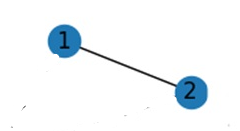

Logically that means that antenna 1 is unlike the antenna 2, i.e. we should be using XOR operation to describe a relationship between these two antennas, as it is presented in the following eample.

In [4]:
assignment2 = antOn.assign(ant1 ^ ant2)
print(assignment2.solve())

antOn\T\; ant1\F\; ant2\T\
antOn\T\; ant1\T\; ant2\F\



Additionally, we can use not-equal (!=) operator and create expression that would have same solutions.

In [5]:
expression2 = ant1 != ant2
print(expression2.solve())

ant1\F\; ant2\T\
ant1\T\; ant2\F\



### Three antennas problem using triangular dependency constrain

The three interfering antennas will form an interference triangle as presented below, where only one antenna should be on at any point of time.

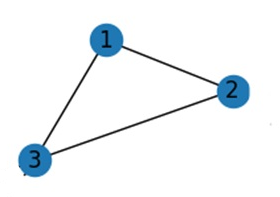

The problem issame as vertices problem in triangle described in the previous chapter. So, we are going to use the same assignment with the triangular dependency constrain.

In [6]:
assignment3 = antOn.assign(((ant1 ^ ant2) | (ant1 ^ ant3)) & (ant1.alike(ant2).alike(ant3)))

To focus the presentation of solutions only on the antennas we will create quantum binder *antennas*, and add all the antenna variables to the bundle.

In [7]:
from dann5.d5 import Qbinder

antennas = Qbinder() << ant1 << ant2 << ant3
print(antennas)
antennas.add(assignment3.compute())
print("Solutions for ", antennas)

ant1\S\ ant2\S\ ant3\S\ 
Solutions for  ant1\S\ ant2\S\ ant3\S\ {
ant1\F\ ant2\T\ ant3\F\ 
ant1\T\ ant2\F\ ant3\F\ 
ant1\F\ ant2\F\ ant3\T\ 
}


### Four antennas problem

First, we will add the 4th antenna to the *antennas* quantum bundle to optimize presentation of calculated antenna solutions. 

In [8]:
antennas.reset()
antennas = antennas << ant4
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ 


In case of a different shape, like the one below, we will need to define a quantum expression/assignment to describe the problem.

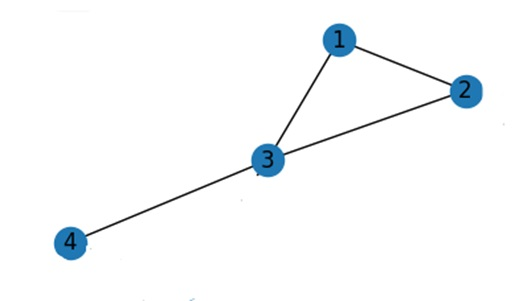

To solve problem, we can logically state that:

1. the state of antennas 1, 2 and 3 has to be different, and

2. the state of antenna 3 has to be different from antennas 4.

based on the above we can conclude that
>
> antennas 1 and 2 might be on when antenna 4 is on, and
>
> antenna 3 never can be on

We are writing an *assignment4* stating the above conditions using *XOR (unlike)* when antennas have to have different values and *alike (NXOR)* method when antennas have the same values.

In [9]:
antF = Qbool("antF", False)
expression4 = ((ant1.alike(ant4)) ^ (ant4.alike(ant2))) & (ant1 ^ ant2) & (ant3 ^ ant4) & (ant3.alike(antF))

print(expression4, "\n")
print(expression4.toString(True).replace(";", ";\n"))

(((((ant1\S\ !^ ant4\S\) ^ (ant4\S\ !^ ant2\S\)) & (ant1\S\ ^ ant2\S\)) & (ant3\S\ ^ ant4\S\)) & (ant3\S\ !^ antF\F\)) 

_&3\S\ = _&2\S\ & _!^4\S\;
 _&2\S\ = _&1\S\ & _^5\S\;
 _&1\S\ = _^3\S\ & _^4\S\;
 _^3\S\ = _!^2\S\ ^ _!^3\S\;
 _!^2\S\ = ant1\S\ !^ ant4\S\;
 _!^3\S\ = ant4\S\ !^ ant2\S\;
 _^4\S\ = ant1\S\ ^ ant2\S\;
 _^5\S\ = ant3\S\ ^ ant4\S\;
 _!^4\S\ = ant3\S\ !^ antF\F\;
 


If we would to review the results of the *expression4*, we will see that there are only 2 solutions, when the above expression has a *True* result, i.e. when the top most auto-generated auxiliary quantum variable (e.g. *_&10*) is *True*.

In [10]:
print(expression4.solve())

_&3\F\; _&2\F\; _&1\F\; _^3\F\; _!^2\F\; ant1\F\; ant4\T\; _!^3\F\; ant4\T\; ant2\F\; _^4\F\; ant1\F\; ant2\F\; _^5\T\; ant3\F\; ant4\T\; _!^4\T\; ant3\F\; antF\F\
_&3\F\; _&2\T\; _&1\T\; _^3\T\; _!^2\F\; ant1\T\; ant4\F\; _!^3\T\; ant4\F\; ant2\F\; _^4\T\; ant1\T\; ant2\F\; _^5\T\; ant3\T\; ant4\F\; _!^4\F\; ant3\T\; antF\F\
_&3\F\; _&2\F\; _&1\T\; _^3\T\; _!^2\F\; ant1\T\; ant4\F\; _!^3\T\; ant4\F\; ant2\F\; _^4\T\; ant1\T\; ant2\F\; _^5\F\; ant3\F\; ant4\F\; _!^4\T\; ant3\F\; antF\F\
_&3\F\; _&2\T\; _&1\T\; _^3\T\; _!^2\T\; ant1\F\; ant4\F\; _!^3\F\; ant4\F\; ant2\T\; _^4\T\; ant1\F\; ant2\T\; _^5\T\; ant3\T\; ant4\F\; _!^4\F\; ant3\T\; antF\F\
_&3\F\; _&2\F\; _&1\T\; _^3\T\; _!^2\T\; ant1\F\; ant4\F\; _!^3\F\; ant4\F\; ant2\T\; _^4\T\; ant1\F\; ant2\T\; _^5\F\; ant3\F\; ant4\F\; _!^4\T\; ant3\F\; antF\F\
_&3\F\; _&2\F\; _&1\F\; _^3\F\; _!^2\F\; ant1\F\; ant4\T\; _!^3\F\; ant4\T\; ant2\F\; _^4\F\; ant1\F\; ant2\F\; _^5\F\; ant3\T\; ant4\T\; _!^4\F\; ant3\T\; antF\F\
_&3\F\; _&2\F\; 

Thus, we are using an assignment to a deterministic quantum variable *antOn* set to *True* to isolate those two correct solutions:

In [11]:
expression4.reset()
assignment4 = antOn.assign(expression4)  

antennas.reset()
antennas.add(assignment4.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ {
ant1\T\ ant2\F\ ant3\F\ ant4\T\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ 
}


The problem can be solved using a combination of quantum comparison operator *not-qual (!=)* rather than quantum logical operation *XOR (^)*. With this approach we will simplify the d5vc by reducing the number of auto-generated auxiliary *XOR* quantum variables, even though the number of d5vc lines will state the same.

In [12]:
compXpr4 = (ant1 != ant2) & ((ant1.alike(ant4)) ^ (ant2.alike(ant4))) & (ant3 != ant4) & (ant4 != antF)
print(compXpr4, "\n")
print(compXpr4.toString(True).replace(";", ";\n"))

print(compXpr4.solve())

antennas.reset()
antennas.add(compXpr4.compute())
print("Solutions for ", antennas)

((((ant1\S\ != ant2\S\) & ((ant1\S\ !^ ant4\S\) ^ (ant2\S\ !^ ant4\S\))) & (ant3\S\ != ant4\S\)) & (ant4\S\ != antF\F\)) 

_&6\S\ = _&5\S\ & ant4\S\;
 _&5\S\ = _&4\S\ & ant3\S\;
 _&4\S\ = ant1\S\ & _^6\S\;
 ant1\S\ != ant2\S\;
 _^6\S\ = _!^5\S\ ^ _!^6\S\;
 _!^5\S\ = ant1\S\ !^ ant4\S\;
 _!^6\S\ = ant2\S\ !^ ant4\S\;
 ant3\S\ != ant4\S\;
 ant4\S\ != antF\F\;
 
_&6\F\; _&5\F\; _&4\T\; ant1\T\; ant2\F\; _^6\T\; _!^5\T\; ant1\T\; ant4\T\; _!^6\F\; ant2\F\; ant4\T\; ant3\F\; ant4\T\; ant4\T\; antF\F\
_&6\F\; _&5\F\; _&4\F\; ant1\F\; ant2\T\; _^6\T\; _!^5\F\; ant1\F\; ant4\T\; _!^6\T\; ant2\T\; ant4\T\; ant3\F\; ant4\T\; ant4\T\; antF\F\

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ {
ant1\T\ ant2\F\ ant3\F\ ant4\T\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ 
}


### Five antennas problem

First, we will add the 5th antenna to the *antennas* quantum bundle to optimize presentation of calculated antenna solutions.

In [13]:
antennas.reset()
antennas = antennas << ant5
print("Present solutions for ", antennas)

Present solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ 


To continue solving the original problem, we add the fifth antenna as represented in a figure below.

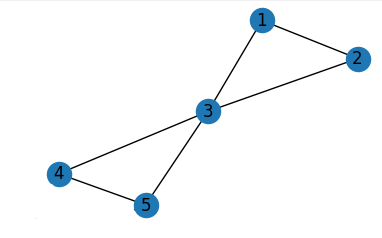

We need to solve a problem of two triangles with a common vertex, antenna 3. Like the problem with 4 antennas, we can observe the following logical relationships between the antennas:
>
> antennas 1 and 2 might be on when one of antennas 4 or 5 is on, and
>
> antenna 3 never can be on

The *twoTrianglesXpr* quantum expression describes these relationships using *EQUAL (==)* and *NOT-EQUAL (!=)* quantum operators combined with *AND (&)* quantum operations.

In [14]:
twoTrianglesXpr = (ant1 != ant2) & (ant3 == antF) & (ant4 != ant5)

antennas.reset()
antennas.add(twoTrianglesXpr.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ {
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\T\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ ant5\F\ 
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\T\ 
ant1\T\ ant2\F\ ant3\F\ ant4\T\ ant5\F\ 
}


We can express the same problem through a quantum assignment using *unlike (XOR)*, *alike (NXOR)* and *AND (&)* quantum operations.

- ***A CHALENGE***: What are ramifications of using *twoTrianglesXpr* vs. *assignment5*?

In [15]:
expression5 = ant1.unlike(ant2) & ant3.alike(antF) & ant4.unlike(ant5)
assignment5 = antOn.assign(expression5)

antennas.reset()
antennas.add(assignment5.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ {
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\T\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ ant5\F\ 
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\T\ 
ant1\T\ ant2\F\ ant3\F\ ant4\T\ ant5\F\ 
}


### Six antennas problem

First, we will add the 6th antenna to the *antennas* quantum bundle to optimize presentation of calculated antenna solutions.

In [16]:
antennas.reset()
antennas = antennas << ant6
print("Present solutions for ", antennas)

Present solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ 


If we are to continue solving our original antennas problem with six antennas, we will have to solve a problem of 3 triangles. Two sharing the same vertex and the other two sharing the same edge, as it is represented in the following figure.

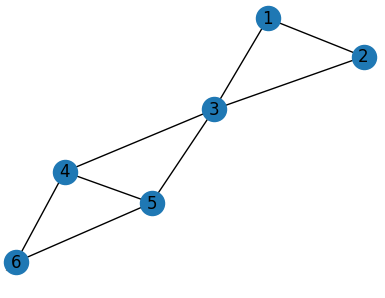

I divided the problem into two expressions. As we see from the following code example the quantum assignment *assign6a*, based on *expression6a* will find all the solutions where the distance between antennas switched on (*True*) is two edges.

In [17]:
expression6a =  (ant1 ^ (ant2| ant3)) & (ant4 ^ (ant5 | ant6)) & (ant4.alike(ant5).alike(ant6)) & (ant1.alike(ant2).alike(ant3)) & (ant3.alike(ant4).alike(ant5))  

assign6a = antOn._(expression6a)
antennas.reset()
antennas.add(assign6a.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ {
ant1\T\ ant2\F\ ant3\F\ ant4\T\ ant5\F\ ant6\F\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ ant5\F\ ant6\F\ 
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\T\ ant6\F\ 
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\T\ ant6\F\ 
ant1\F\ ant2\F\ ant3\T\ ant4\F\ ant5\F\ ant6\T\ 
}


The following quantum assignment *assign6b* based on *expression6b* will find the solutions where distance between antennas switched on is 3 edges.

In [18]:
expression6b = (ant1 ^ ant2) & (ant3.alike(ant4)) & (ant5 ^ ant6) & (ant1 | ant2).alike(ant6) & (ant4.alike(ant5))

assign6b = antOn._(expression6b)

antennas.reset()
antennas.add(assign6b.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ {
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\F\ ant6\T\ 
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\F\ ant6\T\ 
}


Now we just need an union of these two solutions to solve the 6 antennas problem. *OR (|)* operation of two expressions should provide the union of their solutions, as per the final quantum assignment *assign6*. However, as expected, from the next code example, we can see that the assignment has very high complexity with a large *d5vc* footprint.

In [19]:
assign6 = antOn._((expression6a) | (expression6b))
print(assign6)
print(assign6.toString(True).replace(";", ";\n"))

antOn\T\ = ((((((ant1\S\ ^ (ant2\S\ | ant3\S\)) & (ant4\S\ ^ (ant5\S\ | ant6\S\))) & ((ant4\S\ !^ ant5\S\) !^ ant6\S\)) & ((ant1\S\ !^ ant2\S\) !^ ant3\S\)) & ((ant3\S\ !^ ant4\S\) !^ ant5\S\)) | (((((ant1\S\ ^ ant2\S\) & (ant3\S\ !^ ant4\S\)) & (ant5\S\ ^ ant6\S\)) & ((ant1\S\ | ant2\S\) !^ ant6\S\)) & (ant4\S\ !^ ant5\S\)))
antOn\T\ = antOn\T\ | antOn\T\;
 antOn\T\ = _&13\S\ & _!^13\S\;
 _&13\S\ = _&12\S\ & _!^11\S\;
 _&12\S\ = _&11\S\ & _!^9\S\;
 _&11\S\ = _^9\S\ & _^10\S\;
 _^9\S\ = ant1\S\ ^ _|1\S\;
 _|1\S\ = ant2\S\ | ant3\S\;
 _^10\S\ = ant4\S\ ^ _|2\S\;
 _|2\S\ = ant5\S\ | ant6\S\;
 _!^9\S\ = _!^8\S\ !^ ant6\S\;
 _!^8\S\ = ant4\S\ !^ ant5\S\;
 _!^11\S\ = _!^10\S\ !^ ant3\S\;
 _!^10\S\ = ant1\S\ !^ ant2\S\;
 _!^13\S\ = _!^12\S\ !^ ant5\S\;
 _!^12\S\ = ant3\S\ !^ ant4\S\;
 antOn\T\ = _&17\S\ & _!^16\S\;
 _&17\S\ = _&16\S\ & _!^15\S\;
 _&16\S\ = _&15\S\ & _^12\S\;
 _&15\S\ = _^11\S\ & _!^14\S\;
 _^11\S\ = ant1\S\ ^ ant2\S\;
 _!^14\S\ = ant3\S\ !^ ant4\S\;
 _^12\S\ = ant5\S\ ^ ant6

To check if we should run it on the local simulator, we use the following code. In the next chapter, when we deep dive into QUBO interpretations of d5vc, we will talk more about *d5o* library in *dann5* package. In this chapter, we just need to understand that the quantum assignment *assign6* has 41 logical nodes and 102 logical branches. So, there is (2 on 41) of possible combinations to simulate, for each of these 143 energy calculations have to be performed.This would mean that it will take forever to run it on a local simulator if you have a *core I7* laptop.

In [20]:
from dann5.d5o import QuboCompiler, QuboAnalyzer
compiler = QuboCompiler()
assign6.compile(compiler)
analyze = QuboAnalyzer(compiler.qubo())
print("number of nodes: {}, number of branches: {}".format(analyze.nodesNo(), analyze.branchesNo()))

number of nodes: 41, number of branches: 102


So, rather then waiting forever or trying to optimize the quantum assignment *assign6*, we are going to use D-Wave's Hybrid computer to calculate solutions. The 1st time we run the following code the *elapsed_time* will include time required to connect to the Hybrid computer through D-Wave Leap cloud services and to execute code. In my case the processing time was between 7 and 9 seconds.

In [21]:
Solver.Activate('Hybrid')

import time

start = time.time()
evaluations = assign6.compute()
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.6f} seconds")

antennas.reset()
antennas.add(evaluations)
print("Solutions for ", antennas)

CONNECTED to hybrid_binary_quadratic_model_version2.
Elapsed time: 7.709917 seconds
Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ {
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\F\ ant6\T\ 
}


I found D-Wave hybrid computer ideal in testing complex quantum logic with the high d5vc footprint. However, the Hybrid computer always returns just one of the solutions.

When we are reasonably confident that our code is correct, we can run it directly on a D-Wave quantum annealer such as Advantage2 to retrieve a bigger set of most likely solutions.

- **Note**: Due to decoherence and other quantum noise, the result set returned by quantum annealer can be erroneous. The hybrid quantum computer has better quantum error correction with a higher probability of returning a solution, though just one. 

- **Note**: We have found that rerunning the quantum program would help in removing erroneous solutions. Also, we found that running the quantum programs during the night hours usually reduces the probability of errors. So, when you are writing your quantum programs think of ways to simply validate the calculated solutions. 

In [22]:
qAssign6 = antOn._((expression6a) | (expression6b))

Solver.Activate('Advantage2')

start = time.time()
evaluations = assign6.compute()
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.6f} seconds")

antennas.reset()
antennas.add(evaluations)
print("Solutions for ", antennas)

CONNECTED to Advantage2_prototype2.3.
Elapsed time: 1.678870 seconds
Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ {
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\F\ ant6\T\ 
}


### Seven antennas problem

First, we will add the 7th antenna to the *antennas* quantum bundle to optimize presentation of calculated antenna solutions.

In [23]:
antennas.reset()
antennas = antennas << ant7
print("Present solutions for ", antennas)

Present solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ ant7\S\ 


Finally, we came to the initial problem set up with seven antennas. From the next figure we can see that the maximum number of antennas switched on now should be 3.

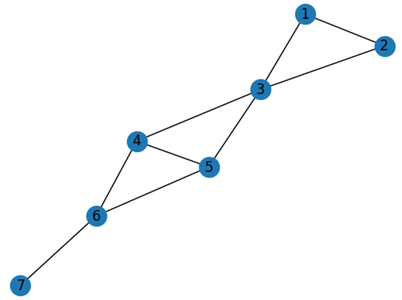

Based on the configuration of antennas, we can conclude the following:

    1. antenna 7 has to be always on to ensure a condition of the maximum number of antennas being on
    2. antennas 3 and 6 have to be in the same state, while antenna 6 has to be different than antenna 7
    3. antennas 1 and 2 have to be in different state
    4. antennas 4 and 5 have to be in different state
    
In the following code example we see that the quantum expression, which formulates the above rules, is not so complex. Thus, we can activate *dann5* quantum simulator again, with a call *Solver.Activate('dann5')*, to use it to calculate all the possible solutions.

In [24]:
ant7 = Qbool("ant7")
expression7 = (ant7 == antOn) & (ant7 ^ ant6) & ant6.alike(ant3) & (ant1 ^ ant2) & (ant4 ^ ant5)
assignment7 = antOn.assign(expression7)

Solver.Activate('dann5')

antennas.reset()
antennas.add(assignment7.compute())
print("Solutions for ", antennas)

Solutions for  ant1\S\ ant2\S\ ant3\S\ ant4\S\ ant5\S\ ant6\S\ ant7\S\ {
ant1\F\ ant2\T\ ant3\F\ ant4\F\ ant5\T\ ant6\F\ ant7\T\ 
ant1\F\ ant2\T\ ant3\F\ ant4\T\ ant5\F\ ant6\F\ ant7\T\ 
ant1\T\ ant2\F\ ant3\F\ ant4\F\ ant5\T\ ant6\F\ ant7\T\ 
ant1\T\ ant2\F\ ant3\F\ ant4\T\ ant5\F\ ant6\F\ ant7\T\ 
}


In **the next chapter, 3.3**, we will be covering the ***Qbin* expressions and assignments to solve practical problems**.